[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DanielAlonsoBastos/AprendizajeProfundo/blob/main/tarea2-cnn-recurrentes-transferencia/2_edades.ipynb)

# Predicción de edades
Daniel Alejandro Alonso Bastos

Entrenamiento de un modelo de regresión para la predicción de edades en el conjunto de datos [UTKFace](https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb). La solución debe de cumplir con los siguientes puntos:
* Implementar la tubería de datos usando el conjunto de rostros alineados y recortados.
* Agregar acrecentamiento de datos usando un espejeo horizontal.
* Dividir aleatoriamente en subconjuntos entrenamiento 80% y prueba 20%.
* Entrenar modelo con arquitectura ResNet vista en la libreta https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet.ipynb, pero cambiando los bloques ResNet por bloques ConNeXt.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

# 1 Preparación

## 1.1 Bibliotecas

In [ ]:
# inspeccionar arquitecturas
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os # sistema de archivos
import matplotlib.pyplot as plt
import random

from PIL import Image # imágenes

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as tvm
from torchvision import transforms as T
from torchvision.ops import Permute

# inspeccion de la arquitectura
from torchsummary import summary

# barras de progreso
from tqdm.auto import trange
from tqdm.auto import tqdm

## 1.2 Auxiliares

In [ ]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
#IMG_SIZE = 64
# tamaño del conjunto de entrenamiento (porcentaje)
TRN_SIZE = 0.8
NUM_WORKERS = 4 # hilos

# parametros para graficas
MARKER = 'o'
MARKER_SIZE = 4

# media y varianza de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Displays examples in a grid."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
      for c in range(cols):
          ax[r, c].imshow(xs[i], cmap='gray')
          ax[r, c].set_title(titles[i])
          ax[r, c].set_xticklabels([])
          ax[r, c].set_yticklabels([])
          i += 1
  fig.tight_layout()
  plt.show()

def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Despliega un lote en una cuadrícula."""
  # denormalizamos
  for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
      x[:, c] = x[:, c] * std + mean 
  x *= 255
  # rotamos canales
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  # desplegamos lote
  display_grid(x, titles, rows, cols, figsize)

def display_losses(losses):
  train_loss, test_loss = zip(*losses)
  plt.plot(train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
  plt.plot(test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
  #plt.ylim([0,100])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Model loss')
  plt.grid()
  plt.show()

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# reproducibilidad
set_seed()

# 2 Datos

## 2.1 Descarga de UTKFace

In [ ]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

File ‘../data/faces/UTKFace.tar.gz’ already there; not retrieving.


Las etiquetas de cada imagen se encuentran dentro del nombre de la imagen, con el siguiente formato:
```
[age]_[gender]_[race]_[date&time].jpg
```
Donde:
* `[age]` es la edad y se representa por un entero $\in[0,116]$
* `[gender]` indica el género donde 0 es para masculino y 1 para femenino.
* `[race]` indica la raza y es un entero del 0 al 4, siendo blanco, negro, asiático, indio y otros.
* `[date&time]` es la fecha y hora que la imagen fue recolectada, siguiendo el formato yyyymmddHHMMSSFFF

In [ ]:
! ls {data_dir} | head -5

100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg


## 2.2 Tubería de datos

Para realizar la división aleatoria de los subconjuntos de prueba y entrenamiento, se obtiene la lista de imágenes descargadas, y después se realiza un muestreo aleatorio sin remplazo de dicha lista del tamaño del subconjunto de entrenamiento, el subconjunto restante sería el de prueba.

In [ ]:
imgs = os.listdir(data_dir) # lista con el nombre de todas las imagenes
trn_size = int(TRN_SIZE * len(imgs)) # tamaño del conjunto de entrenamiento
tst_size = len(imgs) - trn_size # tamaño del conjunto de prueba
# lista con los nombres de las imagenes del conjunto de entrenamiento
trn_names = np.random.choice(imgs,trn_size,replace=False)
# lista con los nombres de las imagenes del conjunto de prueba
tst_names = list(set(imgs)-set(trn_names))

print(f'Número de imagenes: {len(imgs)}')
print(f'Tamaño del conjunto de entrenamiento: {len(trn_names)}')
print(f'Tamaño del conjunto de prueba: {len(tst_names)}')

Número de imagenes: 23708
Tamaño del conjunto de entrenamiento: 18966
Tamaño del conjunto de prueba: 4742


Se implementa una tubería de datos para configurar, leer, transformar y etiquetar las imágenes según su nombre, además de regresar el subconjunto de entrenamiento y prueba según sea especificado.

In [ ]:
class UTKFaceDS:
  
  # configuracion, lectura y transformacion de los datos
  def __init__(self, root, subset, transform=None):
    # guardar la transformacion para las imagenes
    self.transform = transform

    # lista con las rutas a las imagenes
    self.paths = []
    # lista con las etiquetas de las imagenes
    self.labels = []

    # obtener la lista de nombres segun el subconjunto
    names = trn_names if subset == 'train' else tst_names

    # asignar a cada imagen su etiqueta -> edad
    for name in names:
      #age, gender, race, _ = name.split('_')
      age = name.split('_')[0] # [age] es la edad dentro del nombre de la imagen
      self.labels.append(age) # agregar edad
      self.paths.append(f'{data_dir}/{name}') # agregar ruta

  # regresar un elemento
  def __getitem__(self, i):
    # obtener la ruta de la imagen
    path = self.paths[i]
    # carga de la imagen
    x = Image.open(path)
    # aplicar la transformacion
    if self.transform is not None:
      x = self.transform(x)
    # leer etiqueta -> edad
    y = np.array(self.labels[i], np.float32).reshape(1)
    # regresar el ejemplo
    return x,y
  
  # numero de elementos en el conjunto
  def __len__(self):
    return len(self.paths)

## 2.3 Transformaciones y cargadores de datos

### 2.3.1 Conjunto de entrenamiento

En el conjunto de entrenamiento se realiza un acrecentamiento de datos al utilizar un espejeo horizontal.

Tamaño del conjunto de entrenamiento: 18966


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


x shape=torch.Size([32, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


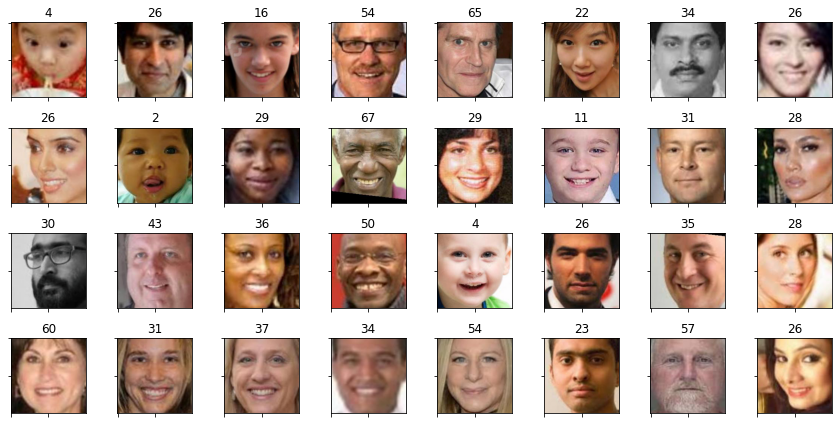

In [ ]:
# transformacion de entrenamiento
trn_tsfm = T.Compose([
    # aumentado de datos
    # espejeo horizontal
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto de entrenamiento
trn_ds = UTKFaceDS(data_dir, 'train', transform=trn_tsfm)
print(f'Tamaño del conjunto de entrenamiento: {len(trn_ds)}')

# entrenamiento
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # numero de procesos paralelos
    num_workers=NUM_WORKERS
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{int(l.item())}' for l in y]
display_batch(x, titles, ROWS, COLS)

### 2.3.2 Conjunto de prueba

Tamaño del conjunto de prueba: 4742
x shape=torch.Size([32, 3, 200, 200]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


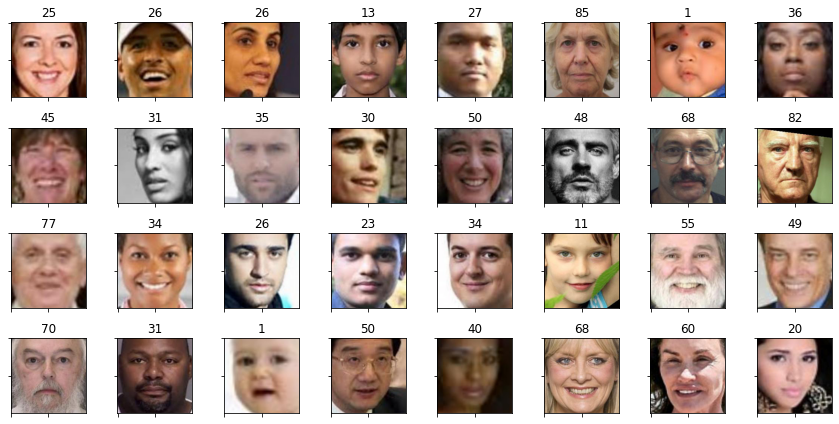

In [ ]:
# transformacion de prueba
tst_tsfm = T.Compose([
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# conjunto de prueba
tst_ds = UTKFaceDS(data_dir, 'test', transform=tst_tsfm)
print(f'Tamaño del conjunto de prueba: {len(tst_ds)}')

# entrenamiento
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # numero de procesos paralelos
    num_workers=NUM_WORKERS
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{int(l.item())}' for l in y]
display_batch(x, titles, ROWS, COLS)

# 3 Modelos

## 3.1 Arquitectura ResNet con bloques ConNeXt

A continuación se realiza una clase para definir el bloque ConvNeXt, en donde se tiene una convolución en profundidad, dicha convolución se realiza al modificar el atributo `group` de `Conv2d` de [PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Después de la convolución en profundidad se realiza una capa de normalización [LN](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), para la cual hay que realizar una permutación previa dado que espera un formato específico del tensor, después se utiliza una capa lineal donde la salida es 4 veces la entrada, después se pasa por la función de activación GELU, para después pasar por otra capa lineal donde la salida es 1/4 veces la entrada, y por último se conecta con una residual.

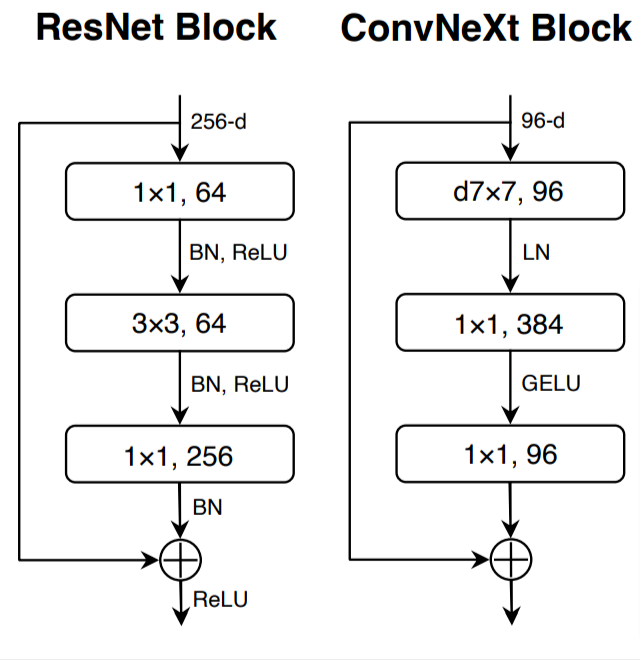

In [ ]:
class ConvNextBlock(nn.Module):

  def __init__(self,dim):
    super(ConvNextBlock, self).__init__()

    self.cnn_block = nn.Sequential(
        # [B, C, W, H] => [B, C, W, H]
        nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=7, 
                  padding=3, groups=dim),
        # para la normalizacion de capa se requiere un formato especial
        # [B, C, W, H] => [B, W, H, C]
        Permute([0,2,3,1]),
        nn.LayerNorm(dim),
        nn.Linear(dim, dim*4), # [B, W, H, 4*C]
        nn.GELU(),
        nn.Linear(dim*4,dim), # [B, W, H, C]
        # regresar al formato original
        # [B, W, H, C] => [B, C, W, H]
        Permute([0,3,1,2]),
    )

  def forward(self, x):
    x1 = self.cnn_block(x)
    x = x1 + x
    return x

Crear una instancia y comprobar que esté funcionando.

In [ ]:
model_convnxt_block = ConvNextBlock(3)
summary(model_convnxt_block, (3, 200, 200), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 200, 200]             150
           Permute-2          [-1, 200, 200, 3]               0
         LayerNorm-3          [-1, 200, 200, 3]               6
            Linear-4         [-1, 200, 200, 12]              48
              GELU-5         [-1, 200, 200, 12]               0
            Linear-6          [-1, 200, 200, 3]              39
           Permute-7          [-1, 3, 200, 200]               0
Total params: 243
Trainable params: 243
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 11.90
Params size (MB): 0.00
Estimated Total Size (MB): 12.36
----------------------------------------------------------------


In [ ]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 200, 200)
y = model_convnxt_block(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 200, 200]) => torch.Size([1, 3, 200, 200])


Una vez generado el bloque ConvNeXt, se realiza una clase que emplea la arquitectura ResNet utilizada en la [libreta](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet.ipynb), pero cambiando los bloques ResNet por bloques ConvNeXt, y cambiando la salida a un problema de regresión, i.e., sale 1 solo valor.

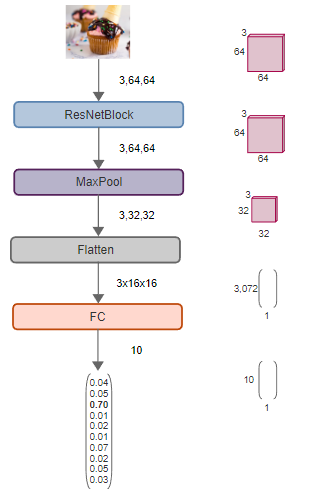

Nota: La imagen corresponde a la arquitectura ResNet vista en la siguiente [libreta](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/2c_cnn_resnet.ipynb).

In [ ]:
class ConvNextNet(nn.Module):

  def __init__(self,dim):
    super(ConvNextNet, self).__init__()

    self.num_features = dim * 100 * 100

    # [N, 3, 200, 200] => [N, 3, 100, 100]
    self.cnn = nn.Sequential(
        # [N, 3, 200, 200] => [N, 3, 200, 200]
        ConvNextBlock(dim),
        # [N, 3, 200, 200] => [N, 3, 100, 100]
        nn.MaxPool2d(kernel_size=2, stride=2),     
    )
    # [N, 3, 100, 100] => [N, 3x100x100]
    self.flatten = nn.Flatten()
    # [N, 3x100x100] => [N,1]
    self.reg = nn.Linear(self.num_features,1)

  def forward(self, x):
    x = self.cnn(x)
    x = self.flatten(x)
    x = self.reg(x)
    return x

Crear una instancia y comprobar que esté funcionando.

In [ ]:
model_rc = ConvNextNet(3)
summary(model_rc, (3, 200, 200), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 200, 200]             150
           Permute-2          [-1, 200, 200, 3]               0
         LayerNorm-3          [-1, 200, 200, 3]               6
            Linear-4         [-1, 200, 200, 12]              48
              GELU-5         [-1, 200, 200, 12]               0
            Linear-6          [-1, 200, 200, 3]              39
           Permute-7          [-1, 3, 200, 200]               0
     ConvNextBlock-8          [-1, 3, 200, 200]               0
         MaxPool2d-9          [-1, 3, 100, 100]               0
          Flatten-10                [-1, 30000]               0
           Linear-11                    [-1, 1]          30,001
Total params: 30,244
Trainable params: 30,244
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/ba

In [ ]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 200, 200)
y = model_rc(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 200, 200]) => torch.Size([1, 1])


## 3.2 Transferencia de conocimiento

Torchvision tiene una familia de modelos preentrenados en ImageNet. En este caso se utilizará [ResNet-50](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) que es una red convolucional con 50 capas de profundidad, se utilizará con transferencia de conocimiento para este problema de regresión.

A continuación se despliega ResNet-50 para ver como está construido, y ver el nombre de la última capa para modificarla con el objetivo de realizar la regresión.

In [ ]:
# cargar ResNet-50
tvm.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class TransferModel(nn.Module):
  def __init__(self, pretrained):
    super(TransferModel, self).__init__()

    # carga del modelo pre entrenado
    self.cnn = tvm.resnet50(pretrained=pretrained)
    # reemplazar la FC (que se llama fc) al ponerle la identidad (puente)
    self.cnn.fc = nn.Identity()

    # numero de inputs de la FC
    in_features = 2048
    # agregar capa de regresion
    self.reg = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features,1)
    )
  
  def forward(self, x):
    # [N, 3, 200, 200] => [N, 2048]
    x = self.cnn(x)
    # [N, 2048] => [N, 1]
    x = self.reg(x)
    return x

  # metodo para congelar los parametros de la CNN
  def freeze_features(self,freeze=True):
    requires_grad = not freeze
    for param in self.cnn.parameters():
      param.requires_grad = requires_grad

# instancia del modelo
model_tf = TransferModel(pretrained=True)
# congelar parametros de la CNN
model_tf.freeze_features()
# modelo en modo de evaluacion
_ = model_tf.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 200, 200)
y = model_tf(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 200, 200]) => torch.Size([1, 1])


In [ ]:
summary(model_tf, (3, 200, 200), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,384
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,384
      BatchNorm2d-14          [-1, 256,

# 4 Ciclo de entrenamiento

In [ ]:
! nvidia-smi

Thu Nov 10 03:17:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def train_epoch(data_loader,model,opt,epoch):
  # loop sobre cada lote en el conjunto de entrenamiento
  for x, y_true in data_loader:
  #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Train'):
    # mover a dispositivo
    x = x.to(device)
    y_true = y_true.to(device)
    # se realiza inferencia
    y_hat = model(x)
    # se calcula la perdida
    loss = F.mse_loss(y_hat, y_true)
    # backprop
    opt.zero_grad() # vaciar los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parametros

def eval_epoch(data_loader, model, epoch):
  # evitar que se regsitren las operaciones en la grafica de computo
  with torch.no_grad():
    # listas para guardar historiales de perdidas y accuracy
    losses = []
    # validación de la época con num_batches
    # si num_batches==None, se usan todos los lotes
    for x, y_true in data_loader:
    #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Test'):
      # mover a dispositivo
      x = x.to(device)
      y_true = y_true.to(device)
      y_hat = model(x) # calculamos y_hat
      loss_b = F.mse_loss(y_hat, y_true) # calculo de la perdida
      losses.append(loss_b.item()) # guardar historial de perdida para el lote
    
    # se obtiene el promedio
    loss = np.mean(losses)
    return loss

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          transfer_learning = False,full_train=False,
          L2lambda=0,progress=True):
  
  # mover modelo a cpu/gpu
  model = model.to(device)

  # historiales
  loss_hist = []

  # optimizadores
  # optimizador seleccionado
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # en caso de emplear transferencia de conocimiento
  # revisar si el entrenamiento es con la ultima capa (full_train=True)
  # o reentrenando toda la red (full_train=False)
  if transfer_learning:
    freeze = not full_train # si no se quiere reentrenar toda la red, se congelan los parametros
    model.freeze_features(freeze)

  # definir si se quiere o no imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  # colocar el modelo en modo de evaluacion
  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # colocar al modelo en modo de entrenamiento
    model.train()
    # entrenamiento de la epoca
    train_epoch(train_dl,model,optimizer,epoch)
    # modelo en modo evaluacion
    model.eval()
    # evaluacion de la epoca en el conjunto de entrenamiento y prueba
    train_loss = eval_epoch(train_dl, model, epoch)
    test_loss = eval_epoch(test_dl, model, epoch)
    # actualizar historial
    loss_hist.append([train_loss,test_loss])

    # impresion del progreso
    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}]')
      
  return loss_hist

La siguiente función tiene como objetivo realizar una evaluación del modelo entrenado y mostrar las imágenes con el valor real $y$ y el valor predicho $\hat{y}$.

Se usa para validar los resultados de los distintos ejercicios de entrenamiento.

In [ ]:
# funcion para realizar una evaluacion junto con sus resultados
def evaluation(dl,model):
  model.to(device).eval()
  with torch.no_grad():
    x, y_true = next(iter(dl))
    y_pred = model(x.to(device))
    titles = []
    for i in range(len(y_true)):
      titles.append(f'y={int(y_true[i].item())},y_h={int(y_pred[i].item())}')
    display_batch(x, titles, ROWS, COLS)

## 4.1 Entrenamiento del modelo con arquitectura ResNet con bloques ConNeXt

En esta sección, se realizó el entrenamiento del modelo con la arquitectura ResNet vista en clase, pero cambiando los bloques ResNet por los bloques ConvNeXt.

El primer ejercicio se realizó con 10 épocas y una tasa de aprendizaje `lr=1e-3`, de lo cual se observa que el entrenamiento es un poco ruidoso, donde a la mitad del entrenamiento se observa un incremento considerable, y después empieza bajar, después de un par de épocas comienza a oscilar.

Dado el comportamiento del entrenamiento, se decidió utilizar un tasa de aprendizaje más pequeña.

In [ ]:
loss_rc = train(model_rc, trn_dl, tst_dl,epochs=10,lr=1e-3,opt='Adam',
          transfer_learning = False,progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[204.31,212.85]
E01 loss=[180.69,186.96]
E02 loss=[172.08,180.28]
E03 loss=[185.70,197.59]
E04 loss=[245.01,252.29]
E05 loss=[194.17,205.87]
E06 loss=[149.14,168.82]
E07 loss=[176.34,196.51]
E08 loss=[153.07,178.33]
E09 loss=[185.02,215.88]


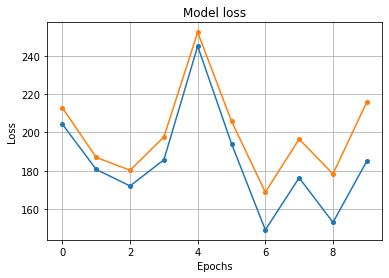

In [ ]:
display_losses(loss_rc)

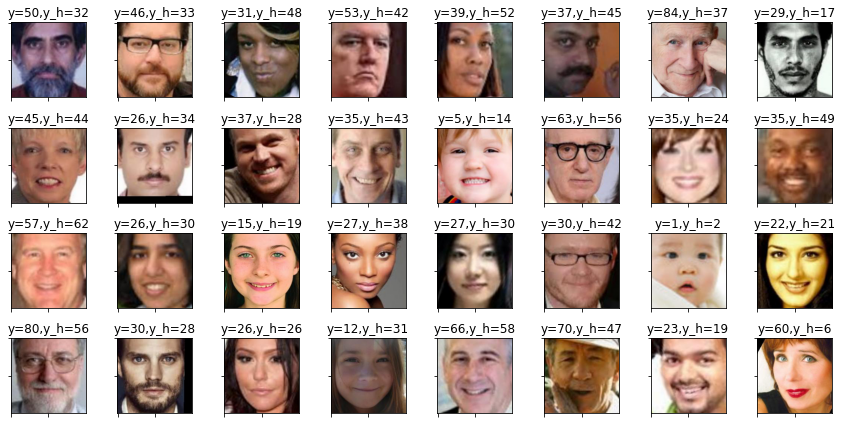

In [ ]:
evaluation(tst_dl, model_rc)

El comportamiento del entrenamiento con `lr=1e-3` era un poco ruidosa, por lo que se disminuyó la tasa de aprendizaje a `lr=1e-4` con el objetivo de hacer el entrenamiento más estable.

In [ ]:
loss_rc = train(model_rc, trn_dl, tst_dl,epochs=10,lr=1e-4,opt='Adam',
          transfer_learning = False,progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[282.67,283.84]
E01 loss=[241.61,244.41]
E02 loss=[228.66,232.28]
E03 loss=[221.18,228.59]
E04 loss=[208.38,215.04]
E05 loss=[205.59,209.16]
E06 loss=[198.98,203.69]
E07 loss=[202.35,205.31]
E08 loss=[191.26,197.09]
E09 loss=[192.06,195.21]


El entrenamiento se comporta de buena manera dado que está disminuyendo y no se muestra algún comportamiento de overfitting, al menos en las primeras 10 épocas de entrenamiento.

En general se observa que al modelo le cuesta predecir las edades de los bebés y también de la gente mayor, donde se comporta relativamente bien es con las personas jóvenes.

Nota: La línea azul representa la función de pérdida del conjunto de entrenamiento y la línea naranaja representa la función de pérdida del conjunto de prueba.

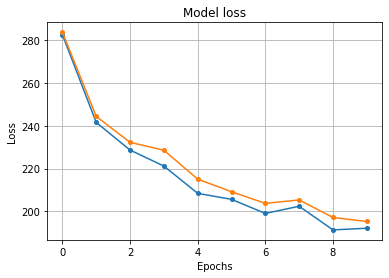

In [ ]:
display_losses(loss_rc)

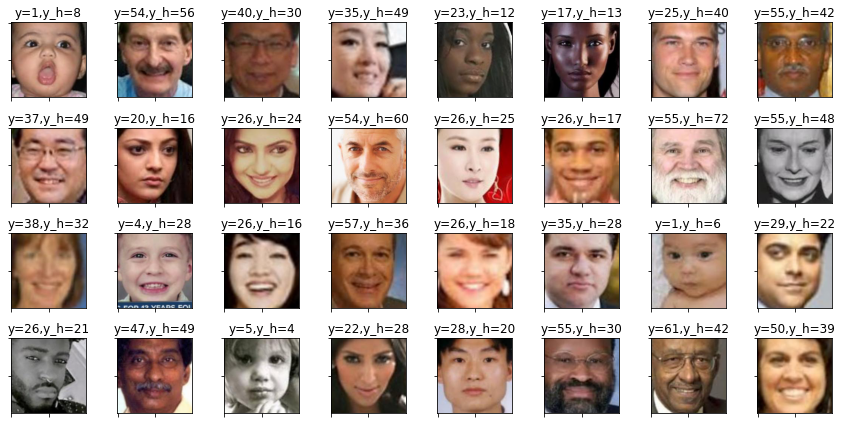

In [ ]:
evaluation(tst_dl, model_rc)

## 4.2 Entrenamiento con transferencia de conocimiento, reentrenando solo la última capa

En esta sección se utilizó transferencia de conocimiento al emplear la red ResNet-50. Como primer ejercicio se congelan los parámetros de la ResNet-50 y solo se entrenan los parámetros de la última capa, teniendo un total de 6,145 parámetros entrenables.

De los resultados se observa que:

*   El tiempo de ejecución del entrenamiento es mayor al ejercicio anterior, si bien el número de parámetros entrenables es menor en esta red, el número de parámetros totales es mucho mayor (23.5 millones contra 30 mil)
*   La pérdida en ambos conjuntos disminuyó respecto al ejercicio anterior, y no se observa overfitting
*   Aún así con la disminución de la pérdida, el modelo sigue fallando en los grupos de menores y mayores de edad.
* Se muestra la ventaja de la transferencia de conocimiento, agregar una red preentrenada ayudó a disminuir la pérdida del modelo, y el entrenamiento tomó un tiempo relativamente pequeño.





In [ ]:
losses_tf_freeze = train(model_tf, trn_dl, tst_dl,epochs=15,lr=1e-3,opt='Adam',
          transfer_learning = True,full_train=False,progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

E00 loss=[182.26,187.62]
E01 loss=[172.16,176.68]
E02 loss=[166.96,172.63]
E03 loss=[162.81,168.00]
E04 loss=[159.59,163.37]
E05 loss=[158.24,163.05]
E06 loss=[154.18,160.02]
E07 loss=[155.00,165.62]
E08 loss=[151.06,157.45]
E09 loss=[148.16,154.98]
E10 loss=[148.57,156.76]
E11 loss=[146.30,152.58]
E12 loss=[148.09,156.70]
E13 loss=[145.49,151.58]
E14 loss=[144.71,153.09]


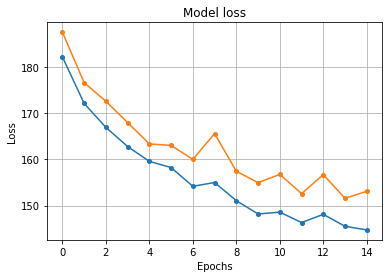

In [ ]:
display_losses(losses_tf_freeze)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


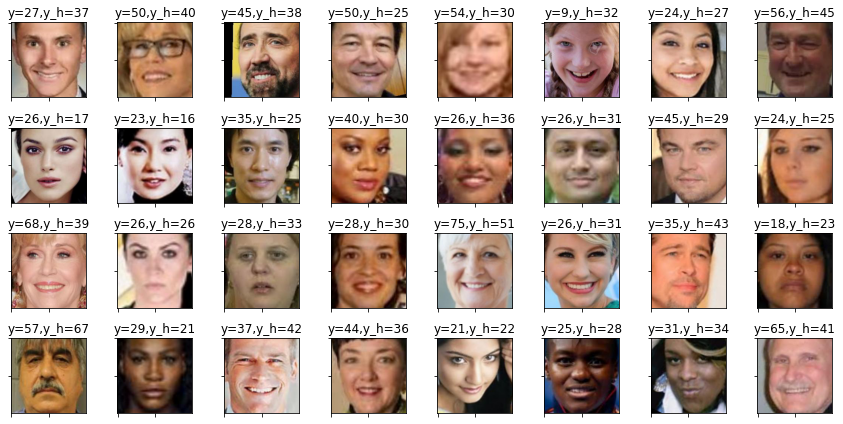

In [ ]:
evaluation(tst_dl, model_tf)

## 4.3 Entrenamiento con transferencia de conocimiento, reentrenando toda la red

En esta sección se entrena la red completa, partiendo de los pesos preentrenados de la ResNet-50, i.e., ahora se tendrán que entrenar alrededor de 23.5 millones de parámetros.

De los resultados se observa que:
* El tiempo de ejecución fue mucho mayor que los ejercicios anteriores dada la cantidad de parámetros entrenables.
* En tempranas épocas ya se cuenta con una pérdida mucho menor que los ejercicios anteriores, pero a las pocas épocas de entrenamiento se muestra un claro overfitting, dado que la función de pérdida en el conjunto de entrenamiento (línea azul) va disminuyendo en función de las épocas, pero la pérdida en el conjunto de prueba (línea naranja) deja de mejorar, i.e., el modelo se está aprendiendo los datos del conjunto de entrenamiento, y esto puede deberse a que el modelo esté sobreparametrizado.
* El modelo extrajo mejores características para los menores de edad, ya no se equivoca tanto como en los ejercicios anteriores, además en las personas cercanos a los 20 o 30 años predice relativamente bien, y también a las personas mayores con rasgos definidos, aunque de este último grupo sigue teniendo errores considerables.

In [ ]:
losses_tf_full = train(model_tf, trn_dl, tst_dl,epochs=15,lr=1e-3,opt='Adam',
          transfer_learning = True,full_train=True,progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

E00 loss=[ 78.31, 84.45]
E01 loss=[ 68.29, 77.15]
E02 loss=[ 57.83, 70.70]
E03 loss=[ 55.13, 68.22]
E04 loss=[ 64.37, 77.35]
E05 loss=[ 60.83, 77.93]
E06 loss=[ 61.61, 76.76]
E07 loss=[ 49.86, 66.67]
E08 loss=[ 49.09, 67.87]
E09 loss=[ 43.49, 66.98]
E10 loss=[ 43.58, 65.11]
E11 loss=[ 44.92, 67.09]
E12 loss=[ 41.68, 67.85]
E13 loss=[ 40.64, 64.97]
E14 loss=[ 39.11, 67.91]


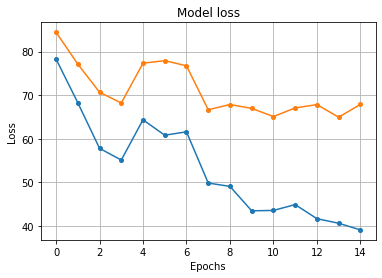

In [ ]:
display_losses(losses_tf_full)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


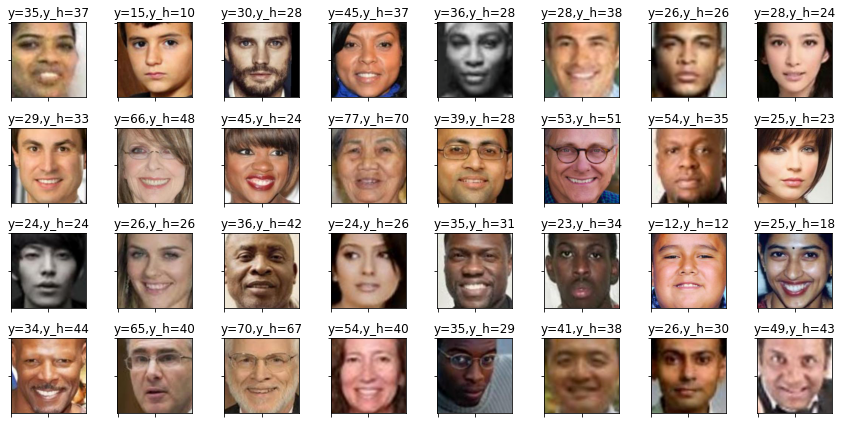

In [ ]:
evaluation(tst_dl, model_tf)